# Imports

In [216]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

import wandb

In [218]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/sharadchitlangia/.netrc


True

In [223]:
wandb_run = wandb.init(project="CovidForecaster")

# Utils

In [4]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [3]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [47]:
df = pd.read_csv("../district_mobility_cases.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.info()
df.columns = ['District', 'Date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'State', 'new cases']

# df['new cases'].dtype == float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181658 entries, 0 to 181657
Data columns (total 10 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   District                                            181658 non-null  object        
 1   Date                                                181658 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline  167731 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   154821 non-null  float64       
 4   parks_percent_change_from_baseline                  169506 non-null  float64       
 5   transit_stations_percent_change_from_baseline       173456 non-null  float64       
 6   workplaces_percent_change_from_baseline             180672 non-null  float64       
 7   residential_percent_change_from_baseline            172356 non-null  float64       

True

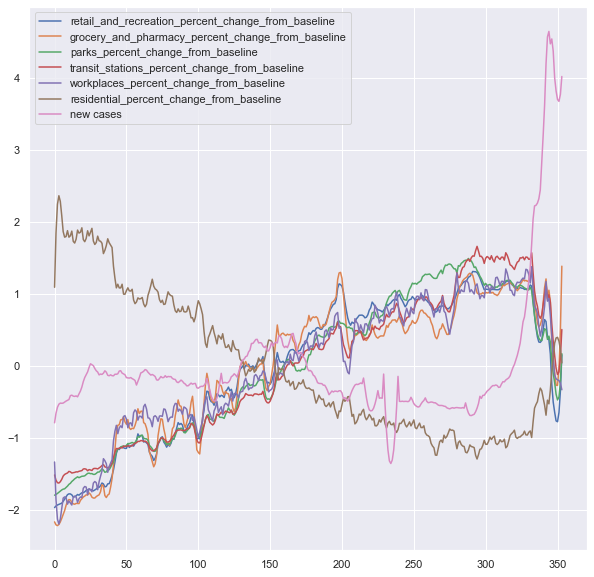

In [202]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import keras

def smooth_plot(data, ax=None, *args, **kwargs):
    data = smoothen_data(data)
    if ax is None:
        plt.plot(data, *args, **kwargs)
    else:
        ax.plot(data, *args, **kwargs)
    
def smoothen_data(data):
    return savgol_filter(data, 11, 3)

def smoothen_df(df: pd.DataFrame, cols=None):
    if cols is None:
        cols = [i for i in df.columns if df[i].dtype==float]
        
    for i in cols:
        df[i] = smoothen_data(df[i])
        
    return df
    

colstoplot = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'new cases']

mumbai = df[df['District']=='Mumbai']
scaler = StandardScaler()
scaled_mumbai = mumbai.copy()

scaled_mumbai[colstoplot] =  scaler.fit_transform(scaled_mumbai[colstoplot])

scaled_mumbai['Date'] = pd.to_datetime(scaled_mumbai['Date'])
scaled_mumbai["Date"] = scaled_mumbai["Date"].dt.year * 30 * 12 + scaled_mumbai["Date"].dt.month * 30 + scaled_mumbai["Date"].dt.day
scaled_mumbai["Date"] -= scaled_mumbai["Date"].min()

fig, ax = plt.subplots(figsize=(10,10))
for col in (colstoplot):
    smooth_plot(scaled_mumbai[col].tolist(), ax=ax, label=col)
ax.legend()
# smooth_plot()


# Algorithm Developement

In [150]:
def sliding_window(data, seq_len, j=0):

    xs = []
    ys = []
    for i in range(0,len(data)-seq_len-1-j,seq_len+1+j):
        x = data[i:(i+seq_len)].drop(["Date"], axis=1).to_numpy()
        y = data[(i+seq_len):i+seq_len+1+j]["new cases"].to_numpy().flatten()#[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [209]:
from tqdm import tqdm_notebook

prev_days = 28
forecast_days = 14

def create_dataset(df, prev_days, forecast_days):
    xtrain, ytrain, xtest, ytest = [], [], [], []
    df = df.drop('State', axis=1)
    for district in tqdm_notebook(df['District'].unique()):
        district_df = df[df['District']==district].copy()
#         scaler = StandardScaler()
#         district_df = district_df.copy()

        district_df[colstoplot] =  scaler.fit_transform(district_df[colstoplot])

        district_df['Date'] = pd.to_datetime(district_df['Date'])
        district_df["Date"] = district_df["Date"].dt.year * 30 * 12 + district_df["Date"].dt.month * 30 + district_df["Date"].dt.day
        district_df["Date"] -= district_df["Date"].min()
        
        if district_df.shape[0]<200:
             continue
        
        
        district_df = smoothen_df(district_df.drop('District',axis=1))
#         district_df = district_df.drop('District',axis=1)

        # df_custom = smoothen_df(df_custom)
#         print(district_df)

        X, y = sliding_window(district_df[district_df['Date']<=250], prev_days, forecast_days-1)
        xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
        print(X.shape, y.shape, xt.shape, yt.shape)
        if 0 in X.shape or 0 in y.shape or 0 in xt.shape or 0 in yt.shape:
            continue
        xtrain.append(X)
        ytrain.append(y)
        xtest.append(xt)
        ytest.append(yt)
        
        
    return np.vstack(xtrain), np.vstack(ytrain), np.vstack(xtest), np.vstack(ytest)

xtrain, ytrain, xtest, ytest = create_dataset(df.dropna(), 28, 14)
# 

In [206]:
xtrain.shape

(9646, 7, 7)

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 28, 7)]      0                                            
__________________________________________________________________________________________________
lstm_64 (LSTM)                  [(None, 25), (None,  3300        input_65[0][0]                   
__________________________________________________________________________________________________
repeat_vector_32 (RepeatVector) (None, 14, 25)       0           lstm_64[0][0]                    
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 14, 25)       5100        repeat_vector_32[0][0]           
                                                                 lstm_64[0][0]             

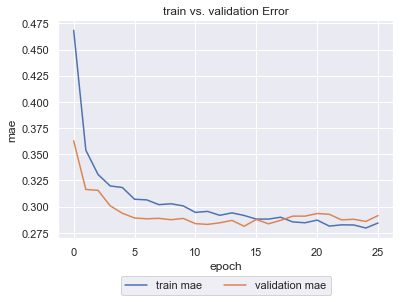

In [211]:
from tqdm.notebook import trange
import tensorflow as tf

r2_scores, test_error_mse, test_error_mae = [], [], []
train, test = {}, {}
train['feats'], train['pred'], train['true'] = {}, {}, {}
test['feats'], test['pred'], test['true'] = {}, {}, {}

n_hidden = 25

# scaled_mumbai = smoothen_df(scaled_mumbai)

# df_custom = scaled_mumbai[scaled_mumbai["District"]=="Mumbai"].drop(["District",'State'], axis=1)

# df_custom = smoothen_df(df_custom)

# X, y = sliding_window(df_custom[df_custom['Date']<=250], prev_days, forecast_days-1)

input_train = keras.Input(shape=(prev_days, 7))
output_train = keras.Input(shape=(forecast_days, 1))

encoder_last_h1, encoder_last_h2, encoder_last_c = keras.layers.LSTM(
 n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

# encoder_last_h1 = keras.layers.BatchNormalization(momentum=0.6)(encoder_last_h1)
# encoder_last_c = keras.layers.BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = keras.layers.TimeDistributed(keras.layers.Dense(1))(decoder)
# out = keras.layers.TimeDistributed(keras.layers.Dense(1))(out)


model = keras.Model(inputs=input_train, outputs=out)
opt = keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', 'mse', 'mape'])
model.summary()

num_epochs = 60

epc = num_epochs
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
history = model.fit(xtrain, ytrain.reshape(-1,forecast_days,1), validation_split=0.2, 
                    epochs=epc, verbose=1, batch_size=32, callbacks=[es])
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# xtest, ytest = sliding_window(df_custom[df_custom['Date']>250], prev_days, forecast_days-1)

y_test_pred = model.predict(xtest)
y_train_pred = model.predict(xtrain)

test_error_mae.append(mean_squared_error(ytest, y_test_pred[:,:,0]))
test_error_mse.append(mean_absolute_error(ytest, y_test_pred[:,:,0]))
r2_scores.append(r2_score(ytest, y_test_pred[:,:,0]))            

# X, y = sliding_window(scaled_df[scaled_df["State"]=="West Bengal"].drop("State", axis=1), 1)

# r2_scores, test_error_mae, test_error_mse, train, test = train_model_with_crossval(
#     model, 
#     X, 
#     y,
#     tscv,
# )

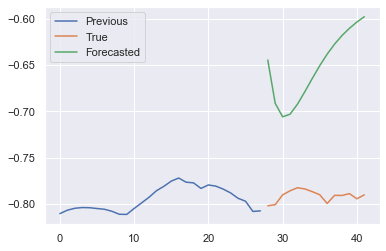

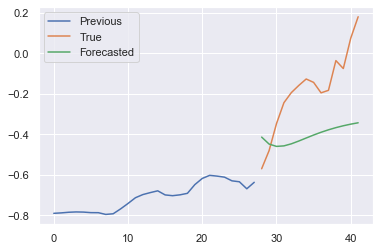

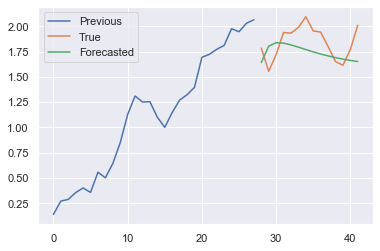

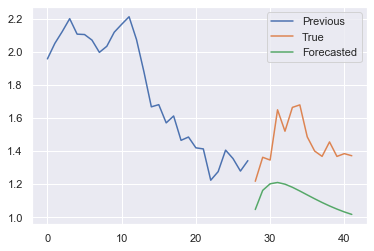

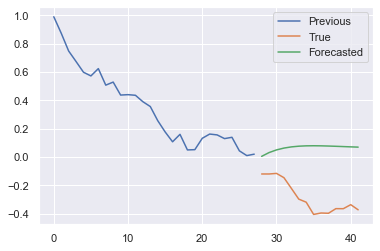

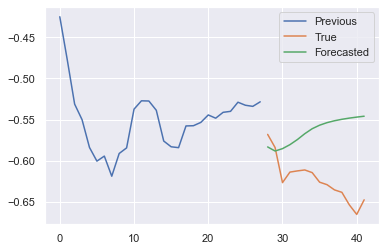

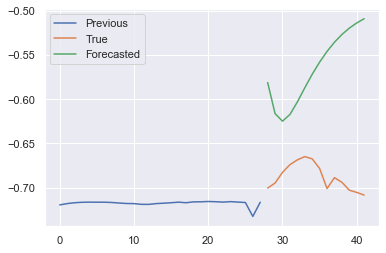

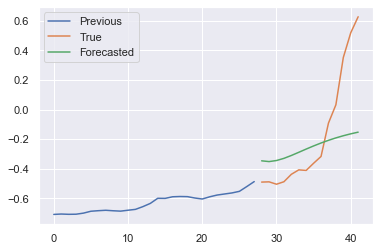

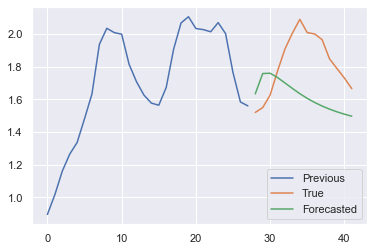

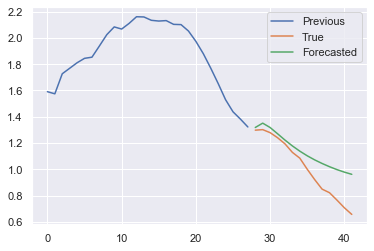

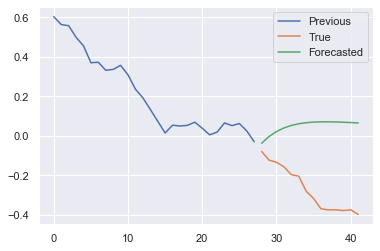

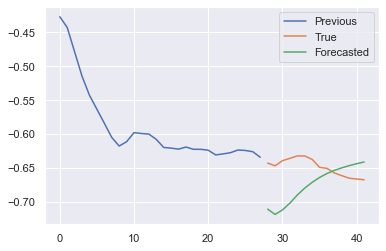

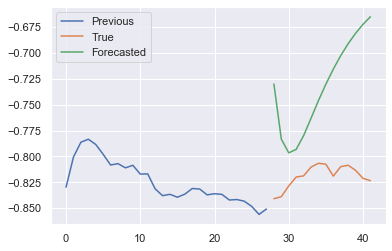

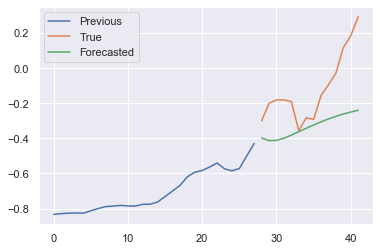

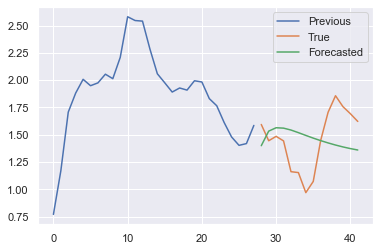

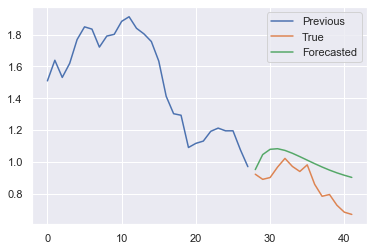

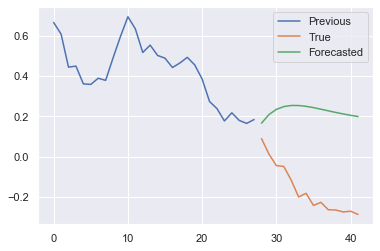

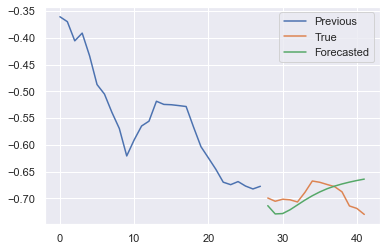

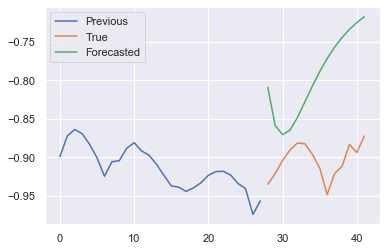

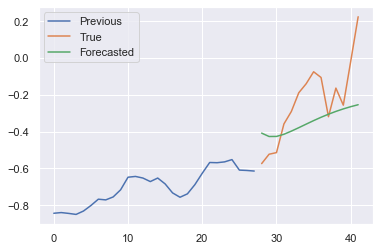

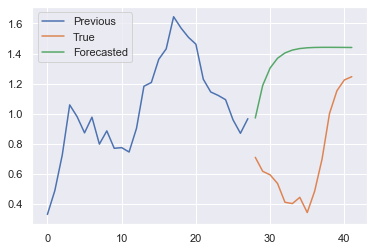

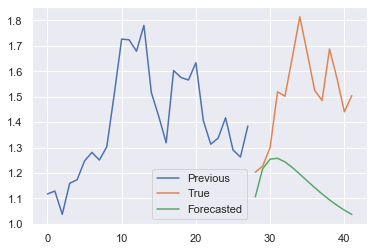

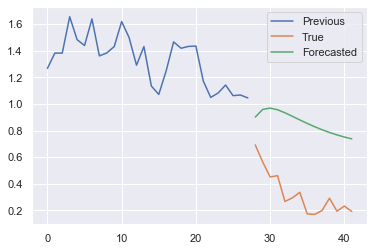

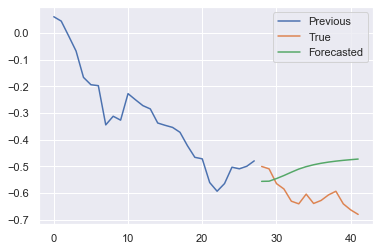

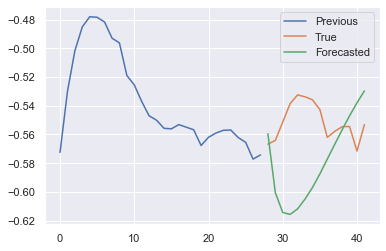

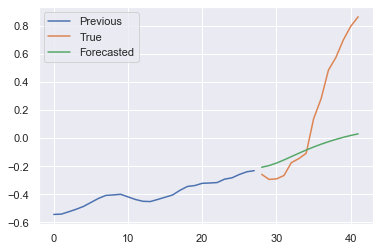

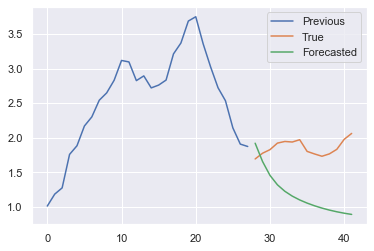

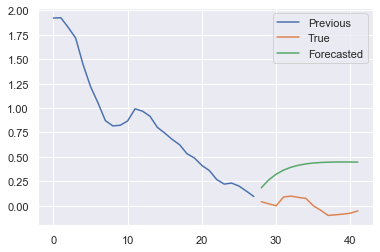

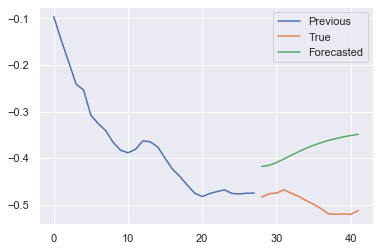

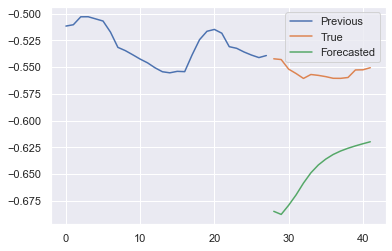

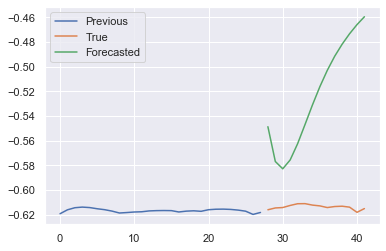

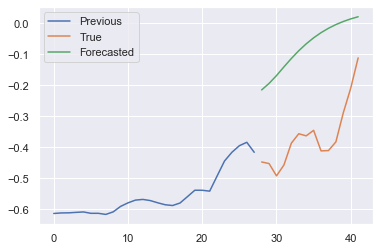

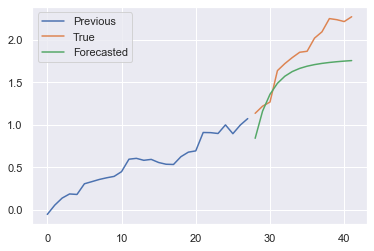

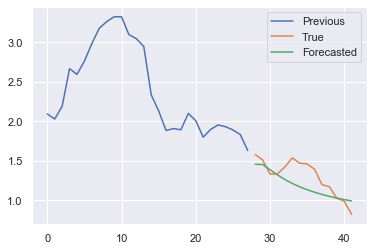

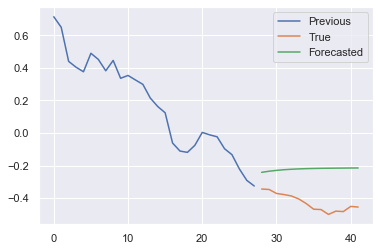

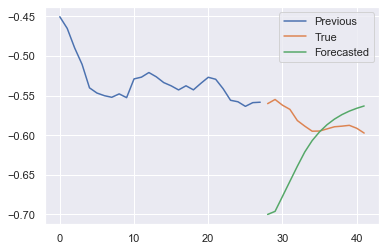

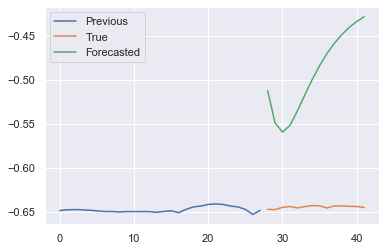

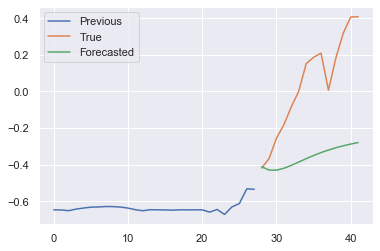

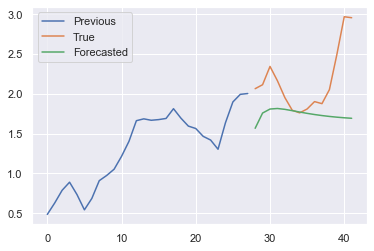

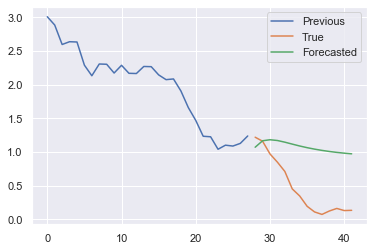

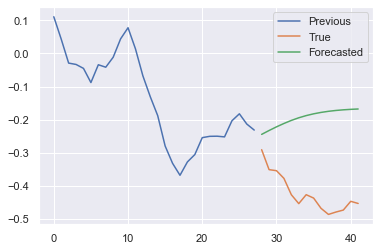

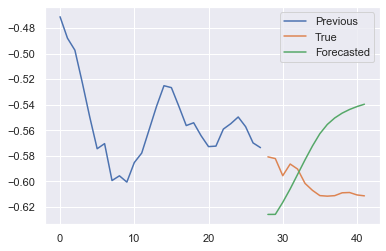

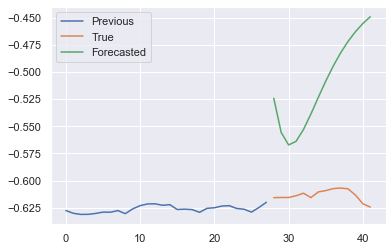

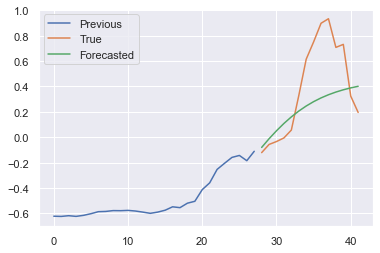

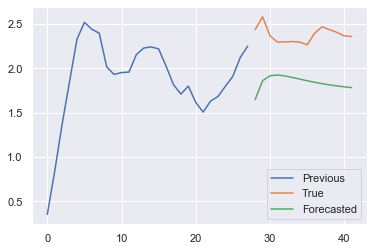

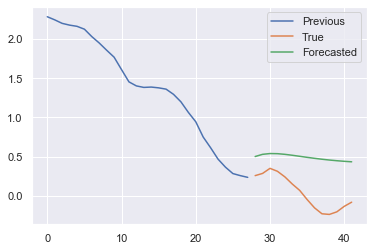

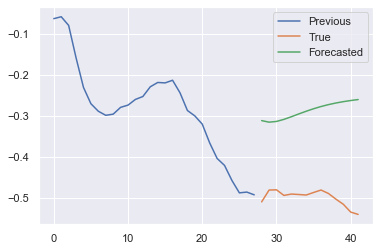

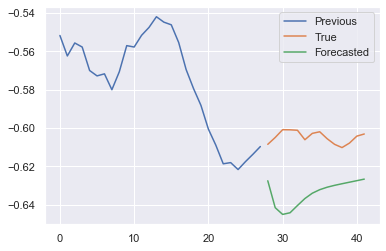

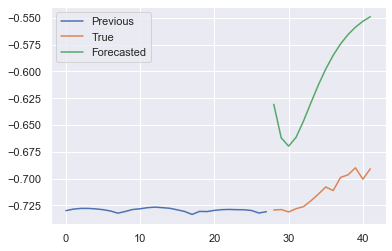

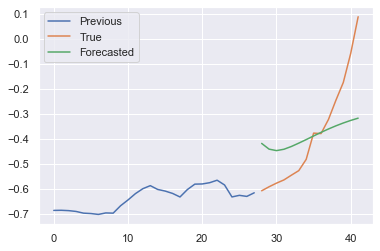

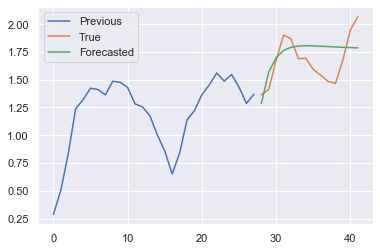

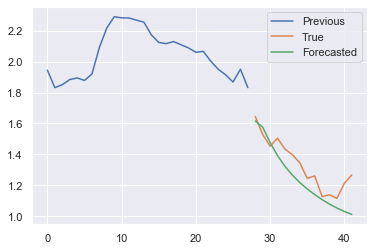

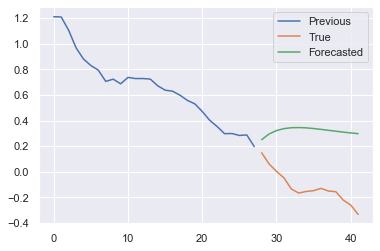

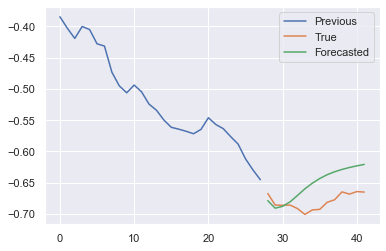

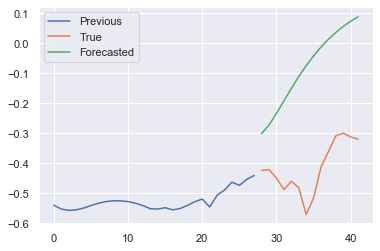

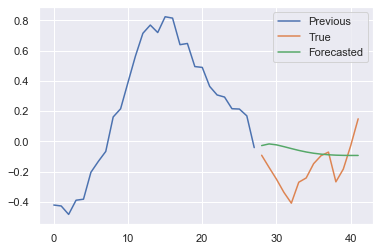

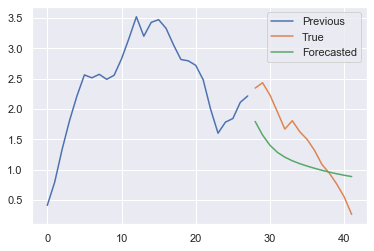

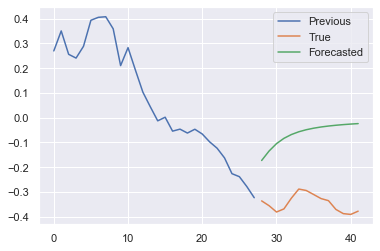

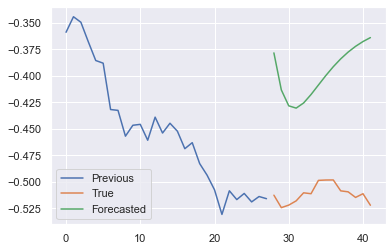

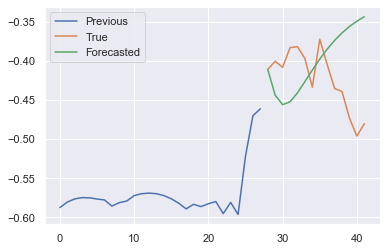

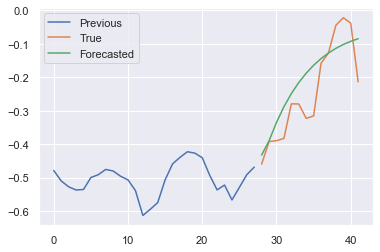

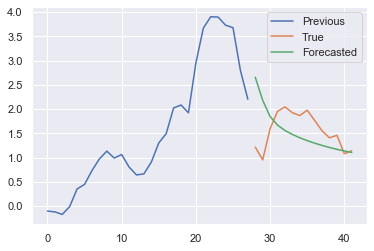

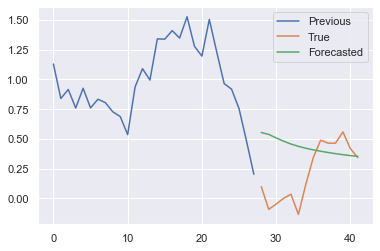

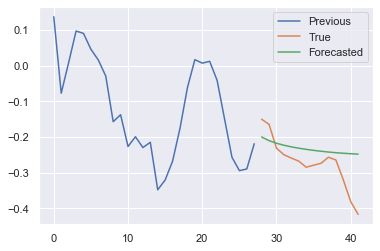

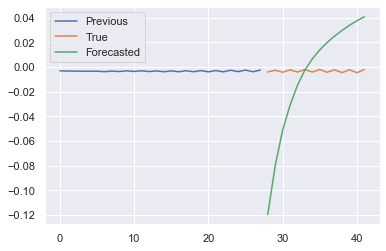

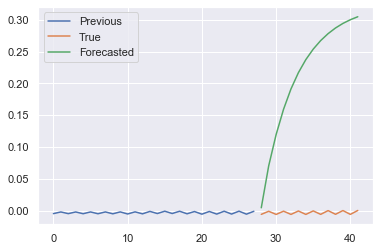

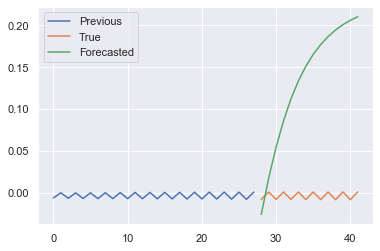

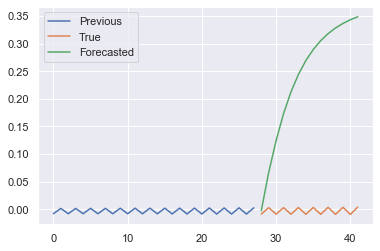

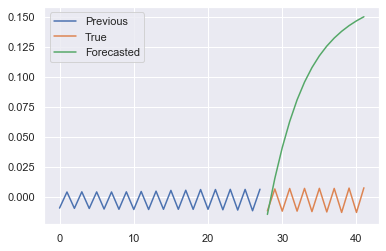

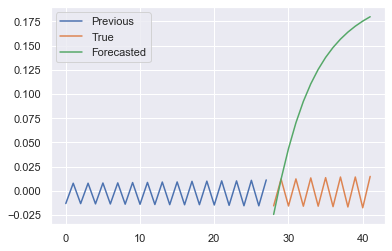

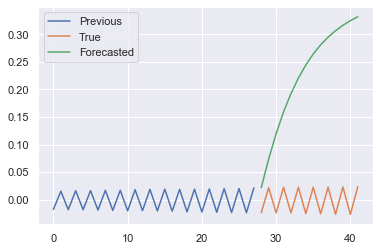

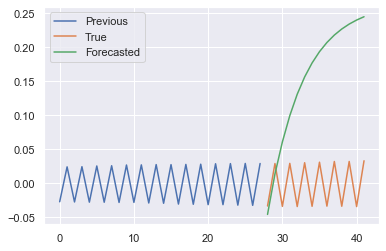

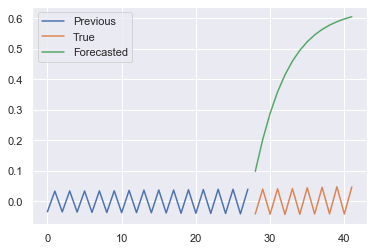

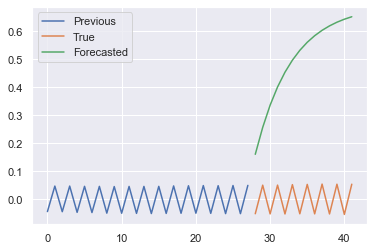

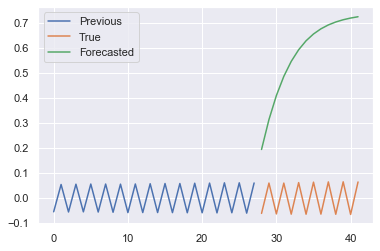

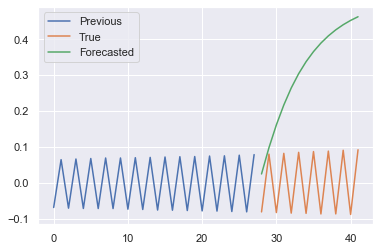

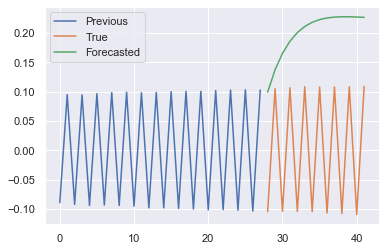

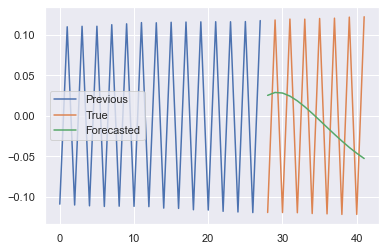

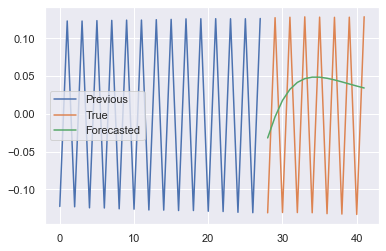

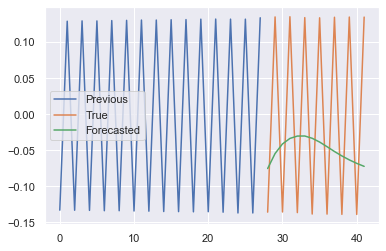

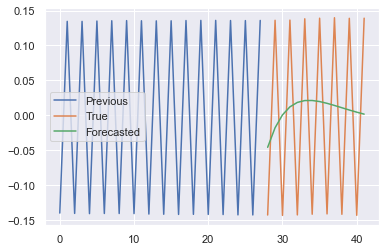

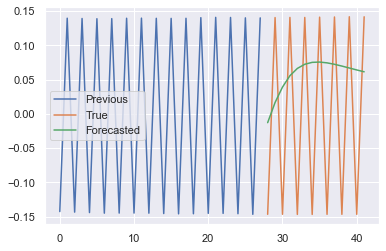

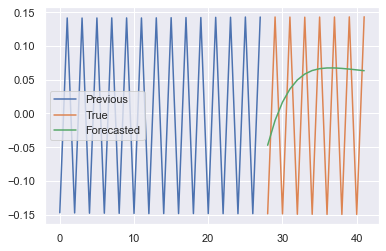

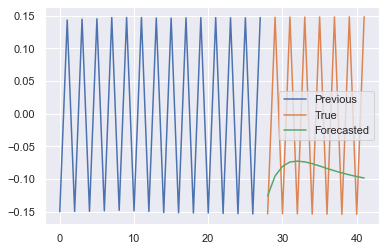

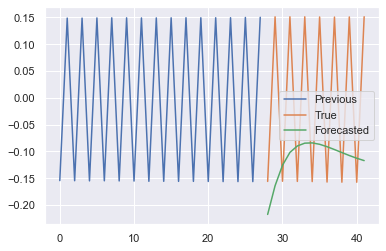

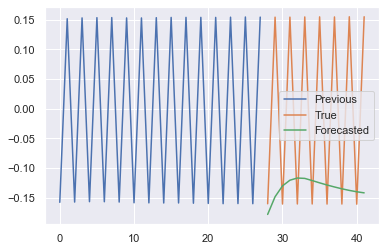

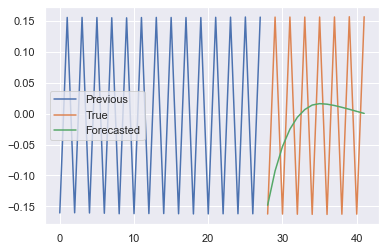

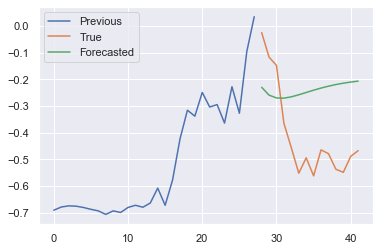

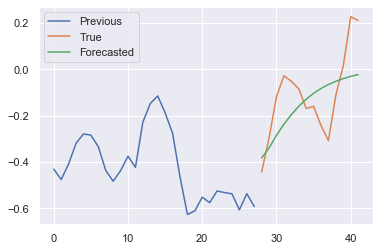

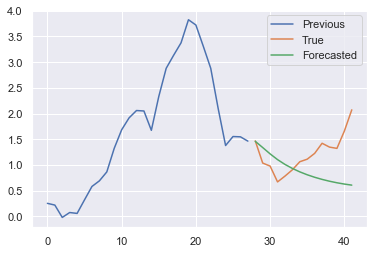

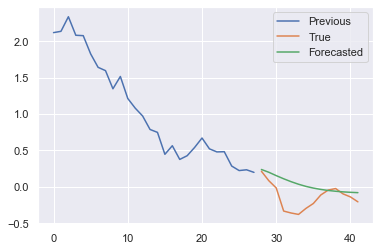

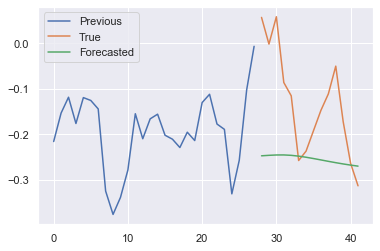

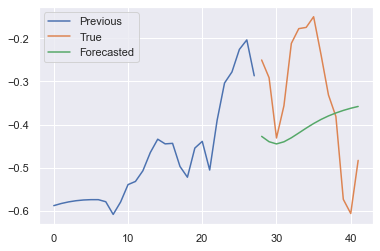

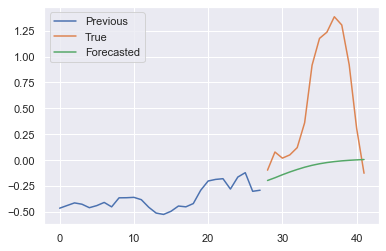

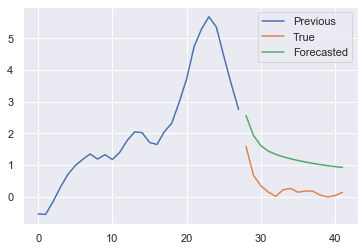

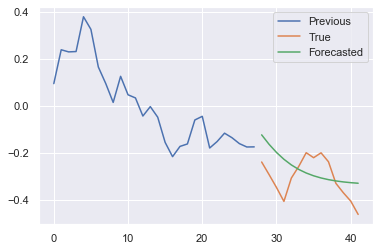

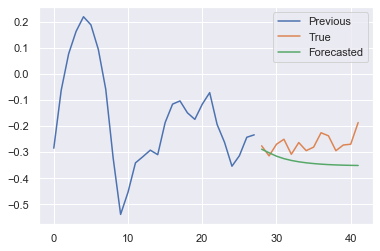

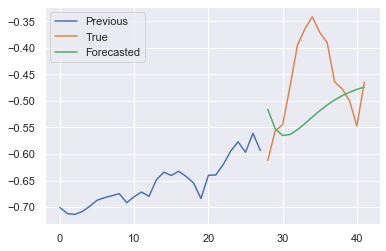

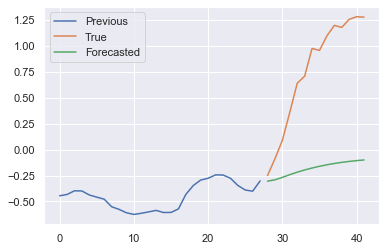

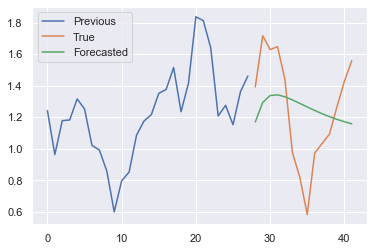

In [212]:
for index in range(100):
#     smoothen_plot
    plt.plot(np.arange(0,prev_days), xtrain[index,:,-1], label='Previous')
    plt.plot(np.arange(prev_days,prev_days+forecast_days), ytrain[index,:], label='True')
    plt.plot(np.arange(prev_days,prev_days+forecast_days), y_train_pred[index,:], label='Forecasted')
    plt.legend()

    plt.show()

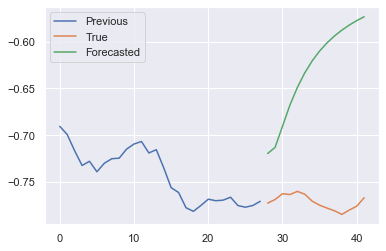

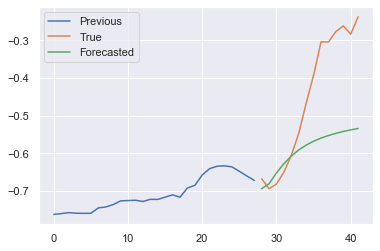

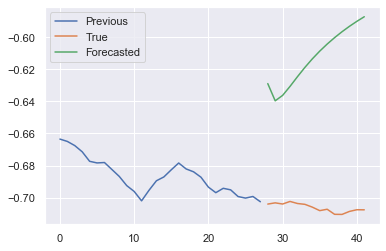

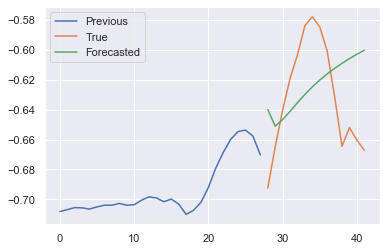

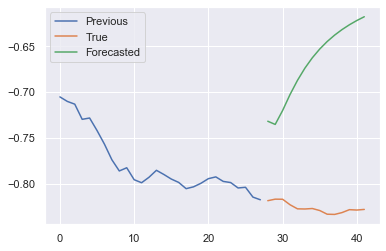

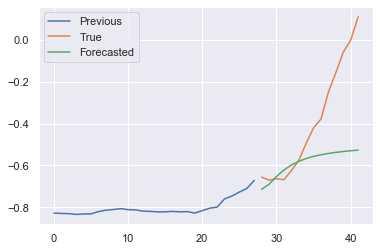

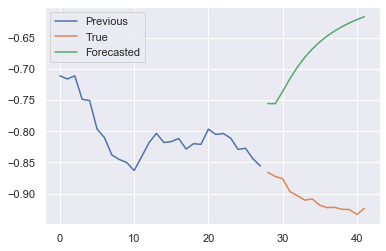

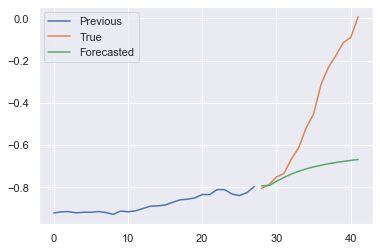

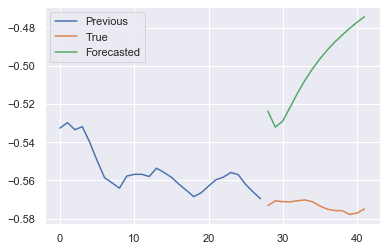

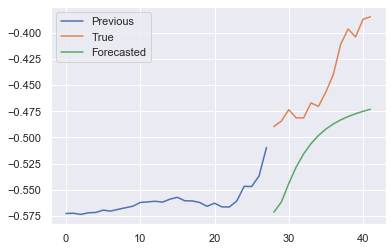

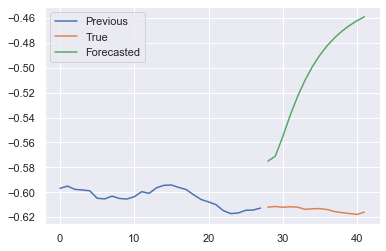

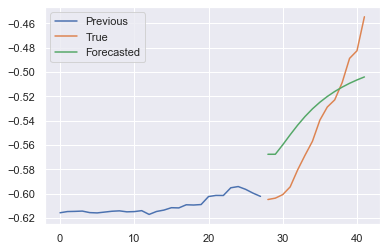

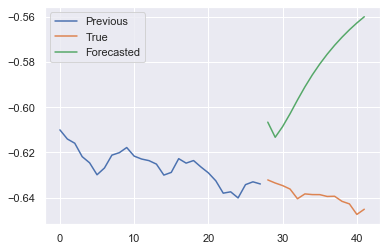

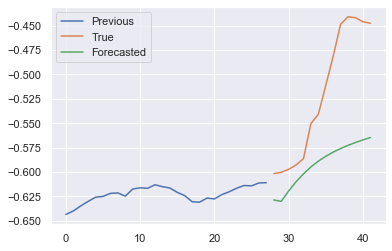

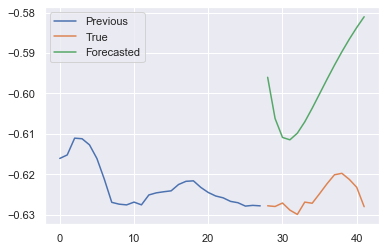

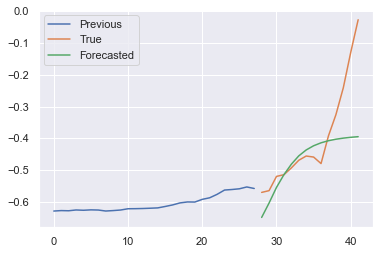

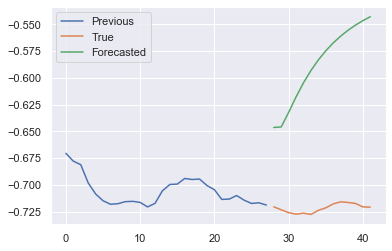

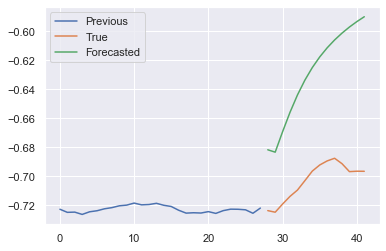

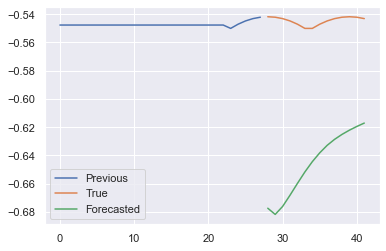

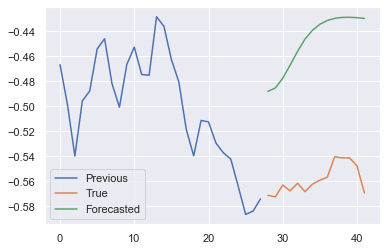

In [213]:
for index in range(20):
    plt.plot(np.arange(0,prev_days), xtest[index,:,-1], label='Previous')
    plt.plot(np.arange(prev_days,prev_days+forecast_days), ytest[index,:], label='True')
    plt.plot(np.arange(prev_days,prev_days+forecast_days), y_test_pred[index,:], label='Forecasted')
    plt.legend()

    plt.show()

In [224]:
wandb_run.log({"r2_scores": r2_scores[0], "test_error_mae":test_error_mae[0], "test_error_mse":test_error_mse[0]})

In [225]:
wandb_run.finish()


_runtime,18
_timestamp,1619137114
_step,0


_runtime,▁
_timestamp,▁
_step,▁
